In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pprint

from skimage.feature import hog
from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, Normalizer
from tqdm import tqdm
from collections import defaultdict

%matplotlib inline
pp = pprint.PrettyPrinter(indent=4)

# import skimage
# from sklearn.model_selection import cross_val_predict
# from skimage.transform import rescale
# import joblib
# from skimage.transform import resize
# from sklearn.base import BaseEstimator, TransformerMixin

#### Funzione per creare il dataset basato sulle hog
Input:
- pixels_per_cell_hog --> da passare alla funzione hog, in forma di tupla, esempio: (8,8)
- cells_per_block_hog --> da passare alla funzione hog, in forma di tupla, esempio: (2,2)
- block_norm_hog --> da passare alla funzione hog, in forma di tupla, esempio: 'L2'

In [7]:
def create_hog_dataset(pixels_per_cell_hog=(8,8), cells_per_block_hog=(4,4), block_norm_hog='L2'):
    path = fr'{os.path.abspath(os.getcwd())}/Images/'
    folders = ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']
    counter = 1
    folder_num = 0

    new_data = defaultdict(list)
    new_data_hog = defaultdict(list)
    new_data_hog_img = defaultdict(list)

    for folder in os.listdir(path):
        if folder in folders:
            new_path = path + folder
            for image in tqdm(os.listdir(new_path)):
                if image[-3:] == 'jpg':
                    mri = imread(os.path.join(new_path, image))
                    mri_hog, mri_hog_img = hog(mri, pixels_per_cell=pixels_per_cell_hog,
                                               cells_per_block=cells_per_block_hog, orientations=9,
                                               visualize=True, block_norm=block_norm_hog)
                    new_data[folders[folder_num]].append(mri)
                    new_data_hog[folders[folder_num]].append(mri_hog)
                    new_data_hog_img[folders[folder_num]].append(mri_hog_img)
            folder_num += 1
        counter += 1
    final_data = []
    for key in new_data_hog.keys():
        if len(new_data_hog[key]) > 0:
            final_data.append(new_data_hog[key])
    return np.array([item for sublist in final_data for item in sublist]), new_data, new_data_hog, new_data_hog_img

#### Funzione per creare la labels
Input:
- labels --> le 4 etichette da assegnare (sotto forma di lista), esempio: ['Non demented', 'Very mild', 'Mild', 'Moderate']
- times_per_labels --> quante volte deve ripetere ognuna delle 4 etichette, esempio: [64, 896, 2240, 3200]

In [3]:
def create_labels(labels, times_per_labels):
    return np.concatenate([np.repeat(labels[0], times_per_labels[0]), np.repeat(labels[1], times_per_labels[1]),
                           np.repeat(labels[2], times_per_labels[2]), np.repeat(labels[3], times_per_labels[3])])

#### Funzione per plottare immagini multiple
Input:
- list_images -> lista dei tipi delle immagini da plottare, esempio: ['Moderate']

In [4]:
def plotta(list_images, size1=8, size2=6):
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(size1, size2)
    [a.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False) for a in ax]
    for i in range(len(list_images)):
        img = list_images[i]
        ax[i].imshow(img[33], cmap='gray')
    plt.show()

#### Creiamo il dataset con le immagini hoggate

In [8]:
X, normal_images, hog_list, hog_images = create_hog_dataset(pixels_per_cell_hog=(8,8),
                                                            cells_per_block_hog=(4,4), block_norm_hog='L2')
X.shape

100%|██████████| 3203/3203 [02:26<00:00, 21.86it/s]


(6400, 24336)

#### Creiamo la lista delle etichette corrispondenti ad ogni immagine

In [ ]:
labels_list = ['Mild', 'Moderate', 'Non demented', 'Very mild']
rep_times = [896, 64, 3200, 2240]
labels = create_labels(labels_list, rep_times)

#### Dividiamo il dataset e le etichette in train e test

In [14]:
X_train, X_test, labels_train, labels_test = train_test_split(X, labels, test_size=0.1,
    shuffle=True, random_state=42)

#### Applichiamo lo StandardScaler, l'SGDClassifier e il fit al nostro train set

In [15]:
scalify = StandardScaler()
X_train_prepared = scalify.fit_transform(X_train)
sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
sgd_clf.fit(X_train_prepared, labels_train)

SGDClassifier(random_state=42)

#### Applichiamo lo StandardScaler e il predict al test set

In [16]:
X_test_prepared = scalify.fit_transform(X_test)
y_pred = sgd_clf.predict(X_test_prepared)

#### Valutiamo le prestazioni del nostro modello

In [17]:
print(np.array(y_pred == labels_test)[:20])
print('')
print('Percentage correct: ', 100*np.sum(y_pred == labels_test)/len(labels_test))

[ True  True False  True  True  True  True  True  True  True  True  True
  True  True  True False  True  True  True  True]

Percentage correct:  80.3125


#### Prova della funzione plotta... mesa proprio che da qualche parte non associamo bene le etichette... porcodio

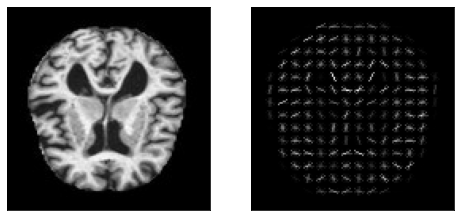

In [10]:
images = [normal_images['Non_Demented'], hog_images['Non_Demented']]
plotta(images)

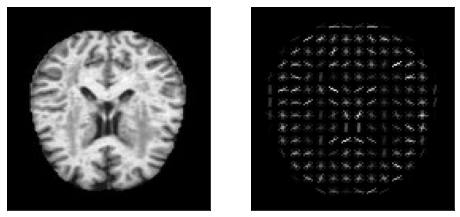

In [11]:
images = [normal_images['Very_Mild_Demented'], hog_images['Very_Mild_Demented']]
plotta(images)

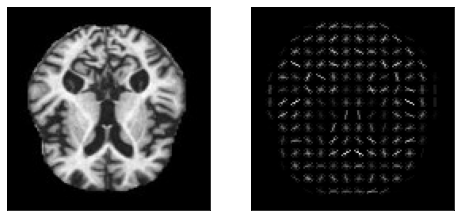

In [12]:
images = [normal_images['Mild_Demented'], hog_images['Mild_Demented']]
plotta(images)

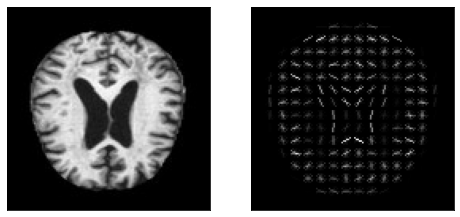

In [13]:
images = [normal_images['Moderate_Demented'], hog_images['Moderate_Demented']]
plotta(images)
